plot_temperature True
plot_salinity True
use_velocity False
use_temperature False
use_salinity False
keep_data False
give_file False
0.0001
0.0001 0.02877697841726619 0.017241379310344827 0.1

iteration: 999 -- 3 %

total time     = 1.00e-01



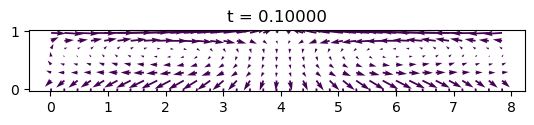

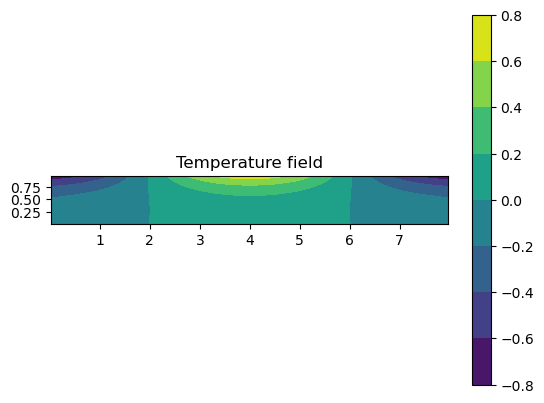

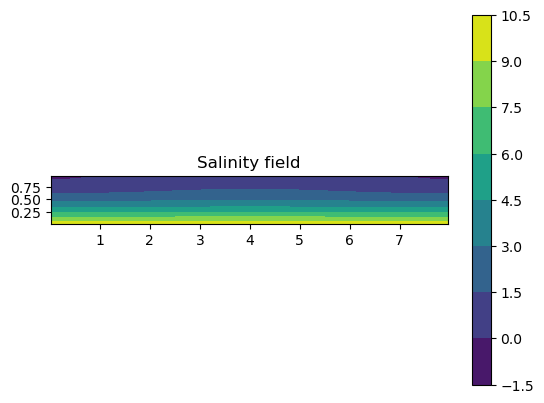


iteration: 1999 -- 6 %

total time     = 2.00e-01



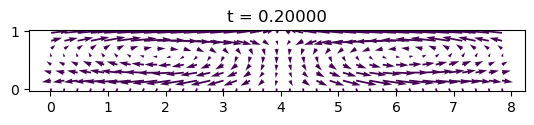

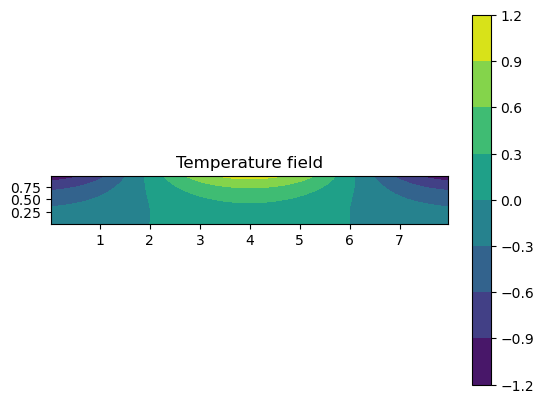

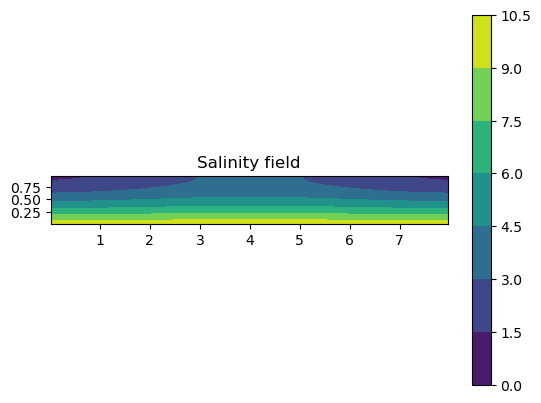


iteration: 2999 -- 9 %

total time     = 3.00e-01



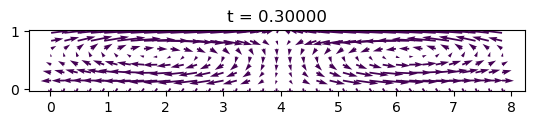

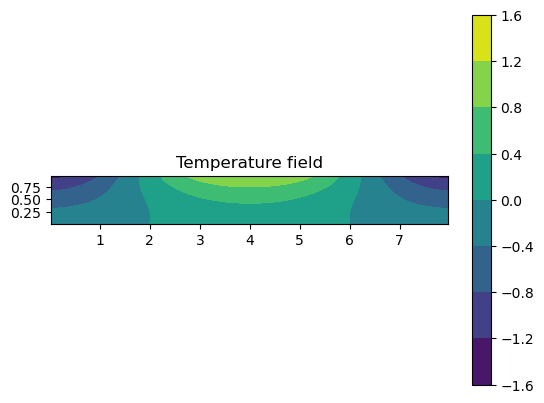

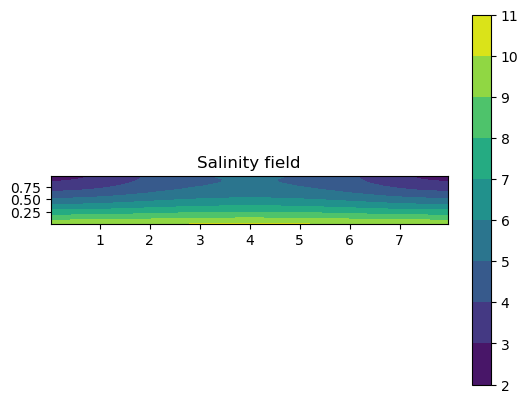

KeyboardInterrupt: 

In [1]:
# -*- coding:utf-8 -*-
#
#   Thermohaline convection : main code

import sys
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as lg


###### affichage graphique
import matplotlib.pyplot as plt
# plt.ion()
                 
%run create_parameters.ipynb
print(dt)
def BuildLAPD():
    """
    Laplacian with Dirichlet BC

    """
    ### Dropping ghost points (-2)
    NXi = nx
    NYi = ny

    ###### 1D Laplace operator

    ###### X-axis
    ### Diagonal terms
    dataNXi = [np.ones(NXi), -2*np.ones(NXi), np.ones(NXi)]   
    
    ### Boundary conditions
    dataNXi[1][0]  = -3.  # Dirichlet
    dataNXi[1][-1] = -3.  # Dirichlet

    ###### Y-axis
    ### Diagonal terms
    dataNYi = [np.ones(NYi), -2*np.ones(NYi), np.ones(NYi)] 
   
    ### Boundary conditions
    dataNYi[1][0]  = -3.  # Dirichlet
    dataNYi[1][-1] = -3.  # Dirichlet

    ###### Their positions
    offsets = np.array([-1,0,1])                    
    DXX = sp.dia_matrix((dataNXi,offsets), shape=(NXi,NXi)) * dx_2
    DYY = sp.dia_matrix((dataNYi,offsets), shape=(NYi,NYi)) * dy_2
    #print(DXX.todense())
    #print(DYY.todense())
    
    ####### 2D Laplace operator
    LAPD = sp.kron(sp.eye(NYi,NYi), DXX) + sp.kron(DYY, sp.eye(NXi,NXi))
    
    return LAPD 

def BuildLAPN():
    """
    Laplacian matrix for Phi with Neumann BC

    The value is set at one point (here [0][1]) to ensure uniqueness
    
    """
    ### Dropping ghost points (-2)
    NXi = nx
    NYi = ny

    ###### 1D Laplace operator

    ###### X-axis
    ### Diagonal terms
    dataNXi = [np.ones(NXi), -2*np.ones(NXi), np.ones(NXi)]   
    
    ### Boundary conditions
    dataNXi[1][0]  = -1.  # Neumann
    dataNXi[1][-1] = -1.  

    ###### Y-axis
    ### Diagonal terms
    dataNYi = [np.ones(NYi), -2*np.ones(NYi), np.ones(NYi)] 
   
    ### Boundary conditions
    dataNYi[1][0]  = -1.  # Neumann
    dataNYi[1][-1] = -1.  # Neumann

    ###### Their positions
    offsets = np.array([-1,0,1])                    
    DXX = sp.dia_matrix((dataNXi,offsets), shape=(NXi,NXi)) * dx_2
    DYY = sp.dia_matrix((dataNYi,offsets), shape=(NYi,NYi)) * dy_2
    #print(DXX.todense())
    #print(DYY.todense())
    
    ####### 2D Laplace operator
    LAP = sp.kron(DXX,sp.eye(NYi,NYi)) + sp.kron(sp.eye(NXi,NXi),DYY)
    
    ####### BUILD CORRECTION MATRIX

    ### Upper Diagonal terms
    dataNYNXi = [np.zeros(NYi*NXi)]
    offset = np.array([1])

    ### Fix coef: 2+(-1) = 1 ==> Dirichlet at a single point
    dataNYNXi[0][1] = -1 * dx_2

    LAP0 = sp.dia_matrix((dataNYNXi,offset), shape=(NYi*NXi,NYi*NXi))
    
    # tmp = LAP + LAP0
    # print(LAP.todense())
    # print(LAP0.todense())
    # print(tmp.todense())
  
    return LAP + LAP0



def LUdecomposition(LAP):
    """
    return the Incomplete LU decomposition 
    of a sparse matrix LAP
    """
    return  lg.splu(LAP.tocsc(),)


def Resolve(splu,RHS):
    """
    solve the system

    SPLU * x = RHS

    Args:
    --RHS: 2D array((NY,NX))
    --splu: (Incomplete) LU decomposed matrix 
            shape (NY*NX, NY*NX)

    Return: x = array[NY,NX]
    
    Rem1: taille matrice fonction des CL 

    """
    # array 2D -> array 1D
    f2 = RHS.ravel()

    # Solving the linear system
    x = splu.solve(f2)

    return x.reshape(RHS.shape)




####
def Laplacien(x):
    """
    calcule le laplacien scalaire 
    du champ scalaire x(i,j)
    
    pas de termes de bord car ghost points

    """
    rst = np.empty((NX,NY))

    coef0 = -2*(dx_2 + dy_2) 
    

    rst[1:-1,1:-1] = ( (x[2:, 1:-1] + x[:-2, 1:-1])*dx_2 +
                       (x[1:-1, 2:] + x[1:-1, :-2])*dy_2 +  
                       (x[1:-1, 1:-1])*coef0 )    
    return rst

def divergence(u,v):
    """
    divergence avec points fantomes
    ne jamais utiliser les valeurs au bord

    """
    tmp = np.empty((NX,NY))
    
    tmp[1:-1,1:-1] = (
        (u[2:, 1:-1] - u[:-2, 1:-1])/dx/2 +
        (v[1:-1, 2:] - v[1:-1, :-2])/dy/2 )
        
    return tmp


###
def VelocityGhostPoints(u,v):
    ### bottom = no slip
    u[:,  0] = -u[:,  1] 
    v[:,  0] = -v[:,  1] 
    ### top = free slip
    u[:, -1] = u[:, -2] 
    v[:, -1] = -v[:, -2] 
    ### right = Neumann 
    u[0,  :] = u[1,  :] 
    v[0,  :] = v[1,  :] 
    ### left = Neumann
    u[-1, :] = u[-2, :] 
    v[-1, :] = v[-2, :] 

    
def PhiGhostPoints(phi):
    """
    copie les points fantomes
    tjrs Neumann

    global ==> pas de return 

    """
    ### bottom               
    phi[:,  0] = phi[:,  1]
    ### top            
    phi[:, -1] = phi[:, -2]
    ### right
    phi[0,  :] = phi[1,  :]
    ### left             
    phi[-1, :] = phi[-2, :]

def TemperatureGhostPoints(T):
    
    ### bottom
    T[:, 0] = -T[:, 1] # fix temperature equals to T0 at the bottom
    ### top
    T[:, -1] = T[:, -2] + dx*temperature_flux # imposing some constant flux at the top4-T[:,-2]#
    ### right
    T[0, :] = T[1, :] # Neumann BC
    ### left
    T[-1, :] = T[-2, :] # Neumann BC

def SalinityGhostPoints(S):
    
    ### bottom
    S[:, 0] = 2*S0-S[:, 1] # fix salinity equals to S0 at the bottom = same as temperature
    ### top
    S[:, -1] = S[:, -2] + dx*salinity_flux # imposing some constant flux at the top
    ### right
    S[0, :] = S[1, :] # Neumann BC
    ### left
    S[-1, :] = S[-2, :] # Neumann BC
####

def TemperatureFlux():
    return np.pi*T0/LX*np.cos(np.arange(NX)/(NX-1)*np.pi*2)*1/np.tanh(np.pi*aspect_ratio)

def SalinityFlux():
    return np.pi*S0/LX*np.cos(np.arange(NX)/(NX-1)*np.pi*2)*1/np.tanh(np.pi*aspect_ratio)
####
def Semilag2(u,v,q):
    """
    Second order semi-Lagrangian advection
    """
  
    qstar=Semilag(u,v,q)
    qtilde=Semilag(-u,-v,qstar)    
    qstar  = q + (q-qtilde)/2;
    ADVq=Semilag(u,v,qstar)

    return ADVq
    
####
def Semilag(u,v,q):
    """
    1st order semi-Lagrangian advection
    """ 
    ADVq = np.zeros((NX,NY))
    
# Matrices where 1 is right, 0 is left or center
    Mx2 = np.sign(np.sign(u[1:-1,1:-1]) + 1.)
    Mx1 = 1. - Mx2

# Matrices where 1 is up, 0 is down or center
    My2 = np.sign(np.sign(v[1:-1,1:-1]) + 1.)
    My1 = 1. - My2

# Matrices of absolute values for u and v
    au = abs(u[1:-1,1:-1])
    av = abs(v[1:-1,1:-1]) 

# Matrices of coefficients respectively central, external, same x, same y
    Cc = (dx - au*dt) * (dy - av*dt)/dx/dy 
    Ce = dt*dt*au * av/dx/dy
    Cmx = (dx - au*dt) * av*dt/dx/dy
    Cmy =  dt*au*(dy - dt*av) /dx/dy


# Computes the advected quantity
    ADVq[1:-1,1:-1] = (Cc * q[1:-1, 1:-1] +            
                       Ce * (Mx1*My1 * q[2:, 2:] + 
                             Mx2*My1 * q[:-2, 2:] +
                             Mx1*My2 * q[2:, :-2] +
                             Mx2*My2 * q[:-2, :-2]) +  
                       Cmx * (My1 * q[1:-1, 2:] +
                              My2 * q[1:-1, :-2])+
                       Cmy * (Mx1 * q[2:, 1:-1] +
                              Mx2 * q[:-2, 1:-1]))

    return ADVq

#########################################
###### MAIN: Programme principal
#########################################


if use_velocity or use_temperature or use_salinity:
    
    with open(file_initial_conditions, 'r') as f:
        
        all_velocities = np.loadtxt(f)
        
        u = use_velocity*all_velocities[:len(all_velocities)//4,:]
        v = use_velocity*all_velocities[len(all_velocities)//4:2*len(all_velocities)//4,:]
        delta_temperature = use_temperature*all_velocities[2*len(all_velocities)//4:3*len(all_velocities)//4,:]
        delta_salinity = use_salinity*all_velocities[3*len(all_velocities)//4:,:]
    
else:
    
    u = np.zeros((NX,NY))    # test of symmetry
    v = np.zeros((NX,NY))
    #for i in range(NY//2,3*NY//4):
        #u[:,i] += np.ones(NX)/2#(np.arange(NX)-np.mean(np.arange(NX)))/NX
        #v[:,i] += -(np.arange(NX)-np.mean(np.arange(NX)))
    delta_temperature = np.zeros((NX,NY))
    delta_salinity = np.zeros((NX,NY))
    
###### Domain Size
### aspect_ratio = LY/LX  

#aspect_ratio = float(.25)

LY = float(1.)
LX = LY/aspect_ratio

###### Grid Size

### (incuding ghost points)

#NX = int(140)
#NY = int(60)

# Number of iterations for the divergence
NI=1


### Taille du domaine reel
nx = NX-2
ny = NY-2

### Nombre d'iterations
#nitermax = int(10001)

### Modulo
modulo = int(1000)

###### Initial conditions



##### Initial values for velocities

#u = np.zeros((NX,NY)) 
#v = np.zeros((NX,NY))

##### Initial values for temperature

#T0 = 1 #temperature at boundary and defining the inward/outward flux
temperature_flux = TemperatureFlux()


def initial_temperature(i, j):
    return T0*np.sinh(j*np.pi/NX)/np.sinh(np.pi*aspect_ratio)*np.cos(i*np.pi/(NX-1)*2)


conduction_temperature = np.fromfunction(np.vectorize(initial_temperature), (NX, NY))
#delta_temperature = np.zeros((NX,NY))
total_temperature = delta_temperature + conduction_temperature


######Initial values for salinity

#S0 = 1 #salinity at boundary and defining the inward/outward flux
salinity_flux = SalinityFlux()

def initial_salinity(i, j):
    return S0*np.sinh(j*np.pi/NX)/np.sinh(np.pi*aspect_ratio)*np.cos(i*np.pi/(NX-1)*2)


conduction_salinity = np.fromfunction(np.vectorize(initial_salinity), (NX, NY))
#delta_salinity = np.zeros((NX,NY))
total_salinity = delta_salinity + conduction_salinity

###### Elements differentiels 

dx = LX/(nx)
dy = LY/(ny)

dx_2 = 1./(dx*dx)
dy_2 = 1./(dy*dy)

### Grid, for plotting only
x = np.linspace(dx/2,LX-dx/2,nx) 
y = np.linspace(dy/2,LY-dy/2,ny)
[xx,yy] = np.meshgrid(x,y) 

### ATTENTION: dt_init calculer la CFL a chaque iteration... 
#dt = 0.0001

t = 0. # total time

# parameters (Prandtl and Rayleigh numbers)
#Pr=.01
#Ra = 1.
#R_rho = .01
#Pr_s=1.

### Tableaux avec points fantomes
### Matrices dans lesquelles se trouvent les extrapolations
ADVu = np.zeros((NX,NY))
ADVv = np.zeros((NX,NY))
ADVt = np.zeros((NX,NY))
ADVs = np.zeros((NX,NY))
### Definition des matrices ustar et vstar
ustar = np.zeros((NX,NY))
vstar = np.zeros((NX,NY))

### Definition de divstar
divstar = np.zeros((NX,NY))

### Definition de la pression phi
phi      = np.zeros((NX,NY))
gradphix = np.zeros((NX,NY))
gradphiy = np.zeros((NX,NY))


###### CONSTRUCTION des matrices et LU decomposition

### Matrix construction for projection step
LAPN = BuildLAPN() 
LUPN = LUdecomposition(LAPN)


#print(np.mean(conduction_temperature)),print(np.max(conduction_temperature)),print(np.min(conduction_temperature))
################
###### MAIN LOOP 
tStart = t
print(dt,dx,dy,Ra*Pr)
for niter in range(nitermax):
        
    t += dt

####    for k in range(NI):

    ###### Advection semi-Lagrangienne (try to make order 2 work ?)
    ADVu=Semilag(u,v,u)
    ADVv=Semilag(u,v,v)

    ###### Diffusion step
    ustar = ADVu + dt*Pr*Laplacien(u) 
    vstar = ADVv + dt*Pr*Laplacien(v) + dt*Pr*Ra*(delta_temperature-1/R_rho*delta_salinity)
        
    ###### Ghost points update
    VelocityGhostPoints(ustar,vstar)
 
    ### Update divstar 
    divstar = divergence(ustar,vstar)
    divstar = divstar - np.mean(divstar[1:-1,1:-1])
    
    ### Solving the linear system
    phi[1:-1,1:-1] = Resolve(LUPN, RHS=divstar[1:-1,1:-1])

    ### update Pressure ghost points 
    PhiGhostPoints(phi)

    ### Update gradphi
    gradphix[1:-1, :] = (phi[2:, :] - phi[:-2, :])/dx/2
    gradphiy[:, 1:-1] = (phi[:, 2:] - phi[:, :-2])/dy/2

    ### Project u
    u = ustar - gradphix
    v = vstar - gradphiy

    ###### Mise a jour des points fantomes
    ###### pour le champ de vitesse et T

    VelocityGhostPoints(u,v)
    
    ###### Diffusion for temperature and salinity
    ###### Semi-lagrangian advection
    ADVt = Semilag(u,v,conduction_temperature+delta_temperature)
    ADVs = Semilag(u,v,conduction_salinity+delta_salinity)
    
    ###### Diffusion for temperature and salinity
    total_temperature = ADVt + dt*Laplacien(delta_temperature)
    total_salinity = ADVs + dt*Pr_s*Laplacien(delta_salinity)
    
    ###### Ghost points update for temperature
    TemperatureGhostPoints(total_temperature)
    SalinityGhostPoints(total_salinity)
    
    ###### Computation of delta_temperature and delta_salinity
    delta_temperature = total_temperature-conduction_temperature
    delta_salinity = total_salinity-conduction_salinity
 
    
    if ((niter+1)%modulo==0):
        ###### logfile
        sys.stdout.write(
            '\niteration: %d -- %i %%\n'
            '\n'
            'total time     = %.2e\n'
            '\n'
            %(niter,                    
              float(niter)/nitermax*100,
              t))
        
        ###### FIGURE draw works only if plt.ion()
        plt.figure(1)
        plotlabel = "t = %1.5f" %(t)
        plt.clf()
        plt.title(plotlabel)
        plt.quiver(xx[::8,::8],yy[::8,::8],np.transpose(u[1:-1:8,1:-1:8]),np.transpose(v[1:-1:8,1:-1:8]),0.9)
        plt.axis('image')
        plt.draw()
        plt.pause(0.001)
        plt.show()
        
        if plot_temperature:
            
            plt.figure(2)
            plotlabel = "t = %1.5f" %(t)
            plt.clf()
            plt.contourf(xx[::4,::4],yy[::4,::4],np.transpose(delta_temperature[1:-1:4,1:-1:4]), cmap='viridis')
            plt.colorbar()
            plt.title('Temperature field')
            plt.axis('image')
            plt.draw()
            plt.pause(0.001)
            plt.show()
        
        if plot_salinity:
            
            plt.figure(3)
            plotlabel = "t = %1.5f" %(t)
            plt.clf()
            plt.contourf(xx[::4,::4],yy[::4,::4],np.transpose(delta_salinity[1:-1:4,1:-1:4]), cmap='viridis')
            plt.colorbar()
            plt.title('Salinity field')
            plt.axis('image')
            plt.draw()
            plt.pause(0.001)
            plt.show()
        
if keep_data:
    if give_file:
        with open(name_file, 'w') as f:

            np.savetxt(f, u, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, v, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, delta_temperature, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, delta_salinity, fmt='%.3e')
    else:
        R_rho_str = "{:.{}f}".format(R_rho, 4)
        Pr_s_str = "{:.{}f}".format(Pr_s, 4)

        with open('Rrho_'+R_rho_str+'_Pr_s_'+Pr_s_str,'w') as f:
            
            np.savetxt(f, u, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, v, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, delta_temperature, fmt='%.3e')
            f.write('\n')
            np.savetxt(f, delta_salinity, fmt='%.3e')